In [4]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [48]:
#########################
############ Hyperparamter
#########################

st_dev = 0.2
learning_rate = 0.5
training_iters = 25000000
batch_size = 512
display_step = 100
display_testing_step = 400
dropout_rate = 0.97

n_input = 11 # Number of features
n_steps = 1 # timesteps
n_hidden = 8 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [6]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99reduced.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [7]:
tf.reset_default_graph()

tf.set_random_seed(0.5)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev, seed=0.5))
}

b = {
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [8]:
num_layers = 4

def RNN(x, W, b):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)
 
    stacked_rnn = []
    for i in range(num_layers):
        stacked_rnn.append(tf.nn.rnn_cell.LSTMCell(n_hidden, state_is_tuple=True, use_peepholes=True))
    

    lstm_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)                
        
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']



In [9]:

pred = RNN(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [10]:
# Initializing the variables
init = tf.global_variables_initializer()


In [49]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    losses = {'train':[], 'validation':[]}
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        offset_val = (step * batch_size) % (y_test.shape[0] - batch_size)
        
        # Generate minibatches for training and validating.
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        batch_val_x = x_test[offset_val:(offset_val + batch_size), :]
        batch_val_y = y_test[offset_val:(offset_val + batch_size), :]
        
        # Reshape data to feed into RNN
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        batch_val_x = batch_val_x.reshape((batch_size, n_steps, n_input))
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        loss_test = sess.run(cost, feed_dict={x: batch_val_x, y: batch_val_y})

        if step % display_step == 0:

            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Loss= " + \
                  "{:.6f}".format(loss_test)
                        
        losses['train'].append(loss)
        losses['validation'].append(loss_test)
        step += 1
            
    print("Optimization Finished!")

    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input)), keep_prob:1.0})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)
    
    

Iter 51200, Minibatch Loss= 1.934957, Minibatch Val Loss= 1.931065
Iter 102400, Minibatch Loss= 0.864282, Minibatch Val Loss= 0.883941
Iter 153600, Minibatch Loss= 0.566620, Minibatch Val Loss= 1.059951
Iter 204800, Minibatch Loss= 0.133014, Minibatch Val Loss= 0.133014
Iter 256000, Minibatch Loss= 0.045425, Minibatch Val Loss= 0.045425
Iter 307200, Minibatch Loss= 0.022936, Minibatch Val Loss= 0.023930
Iter 358400, Minibatch Loss= 0.116806, Minibatch Val Loss= 0.112366
Iter 409600, Minibatch Loss= 0.057284, Minibatch Val Loss= 3.595828
Iter 460800, Minibatch Loss= 0.291980, Minibatch Val Loss= 1.825336
Iter 512000, Minibatch Loss= 0.457581, Minibatch Val Loss= 1.014954
Iter 563200, Minibatch Loss= 0.340104, Minibatch Val Loss= 0.360566
Iter 614400, Minibatch Loss= 0.446705, Minibatch Val Loss= 0.446673
Iter 665600, Minibatch Loss= 0.288781, Minibatch Val Loss= 0.288781
Iter 716800, Minibatch Loss= 0.080777, Minibatch Val Loss= 3.632600
Iter 768000, Minibatch Loss= 0.035946, Minibatch 

Iter 6195200, Minibatch Loss= 0.001539, Minibatch Val Loss= 0.843282
Iter 6246400, Minibatch Loss= 0.001101, Minibatch Val Loss= 0.630905
Iter 6297600, Minibatch Loss= 0.000413, Minibatch Val Loss= 0.002349
Iter 6348800, Minibatch Loss= 0.001635, Minibatch Val Loss= 3.735322
Iter 6400000, Minibatch Loss= 0.000302, Minibatch Val Loss= 0.001300
Iter 6451200, Minibatch Loss= 0.046726, Minibatch Val Loss= 0.003607
Iter 6502400, Minibatch Loss= 0.082580, Minibatch Val Loss= 2.324157
Iter 6553600, Minibatch Loss= 0.091426, Minibatch Val Loss= 0.003891
Iter 6604800, Minibatch Loss= 0.003659, Minibatch Val Loss= 0.003659
Iter 6656000, Minibatch Loss= 0.001913, Minibatch Val Loss= 1.152061
Iter 6707200, Minibatch Loss= 0.001278, Minibatch Val Loss= 0.001278
Iter 6758400, Minibatch Loss= 0.031610, Minibatch Val Loss= 0.000949
Iter 6809600, Minibatch Loss= 0.000395, Minibatch Val Loss= 3.914289
Iter 6860800, Minibatch Loss= 0.001292, Minibatch Val Loss= 0.001292
Iter 6912000, Minibatch Loss= 0.01

Iter 12288000, Minibatch Loss= 0.001090, Minibatch Val Loss= 0.048249
Iter 12339200, Minibatch Loss= 0.036320, Minibatch Val Loss= 1.987655
Iter 12390400, Minibatch Loss= 0.092124, Minibatch Val Loss= 0.007697
Iter 12441600, Minibatch Loss= 0.346224, Minibatch Val Loss= 0.004570
Iter 12492800, Minibatch Loss= 0.004465, Minibatch Val Loss= 0.004465
Iter 12544000, Minibatch Loss= 0.002401, Minibatch Val Loss= 0.462268
Iter 12595200, Minibatch Loss= 0.001563, Minibatch Val Loss= 0.012969
Iter 12646400, Minibatch Loss= 0.001136, Minibatch Val Loss= 0.052893
Iter 12697600, Minibatch Loss= 0.000237, Minibatch Val Loss= 0.001415
Iter 12748800, Minibatch Loss= 0.001287, Minibatch Val Loss= 0.001287
Iter 12800000, Minibatch Loss= 0.002827, Minibatch Val Loss= 0.000984
Iter 12851200, Minibatch Loss= 0.012780, Minibatch Val Loss= 0.000787
Iter 12902400, Minibatch Loss= 0.000610, Minibatch Val Loss= 0.010252
Iter 12953600, Minibatch Loss= 0.000499, Minibatch Val Loss= 0.009220
Iter 13004800, Minib

Iter 18329600, Minibatch Loss= 0.000421, Minibatch Val Loss= 0.015228
Iter 18380800, Minibatch Loss= 0.001189, Minibatch Val Loss= 0.008340
Iter 18432000, Minibatch Loss= 0.004018, Minibatch Val Loss= 0.001108
Iter 18483200, Minibatch Loss= 0.001982, Minibatch Val Loss= 0.000790
Iter 18534400, Minibatch Loss= 0.001307, Minibatch Val Loss= 0.245867
Iter 18585600, Minibatch Loss= 0.000955, Minibatch Val Loss= 0.000955
Iter 18636800, Minibatch Loss= 0.000235, Minibatch Val Loss= 0.001423
Iter 18688000, Minibatch Loss= 0.001113, Minibatch Val Loss= 0.001113
Iter 18739200, Minibatch Loss= 0.000106, Minibatch Val Loss= 0.046201
Iter 18790400, Minibatch Loss= 0.010241, Minibatch Val Loss= 0.000184
Iter 18841600, Minibatch Loss= 0.037210, Minibatch Val Loss= 0.039958
Iter 18892800, Minibatch Loss= 0.126494, Minibatch Val Loss= 0.301252
Iter 18944000, Minibatch Loss= 0.081670, Minibatch Val Loss= 0.081670
Iter 18995200, Minibatch Loss= 0.034468, Minibatch Val Loss= 0.034468
Iter 19046400, Minib

Iter 24371200, Minibatch Loss= 0.002777, Minibatch Val Loss= 0.861434
Iter 24422400, Minibatch Loss= 0.001670, Minibatch Val Loss= 0.001670
Iter 24473600, Minibatch Loss= 0.001210, Minibatch Val Loss= 0.001210
Iter 24524800, Minibatch Loss= 0.041418, Minibatch Val Loss= 0.000109
Iter 24576000, Minibatch Loss= 0.000179, Minibatch Val Loss= 0.001417
Iter 24627200, Minibatch Loss= 0.001057, Minibatch Val Loss= 3.141675
Iter 24678400, Minibatch Loss= 0.018616, Minibatch Val Loss= 0.055683
Iter 24729600, Minibatch Loss= 0.000730, Minibatch Val Loss= 0.005739
Iter 24780800, Minibatch Loss= 0.030508, Minibatch Val Loss= 0.006105
Iter 24832000, Minibatch Loss= 0.004695, Minibatch Val Loss= 0.000277
Iter 24883200, Minibatch Loss= 0.002298, Minibatch Val Loss= 0.113558
Iter 24934400, Minibatch Loss= 0.001536, Minibatch Val Loss= 0.781781
Iter 24985600, Minibatch Loss= 0.001157, Minibatch Val Loss= 1.738383
Optimization Finished!


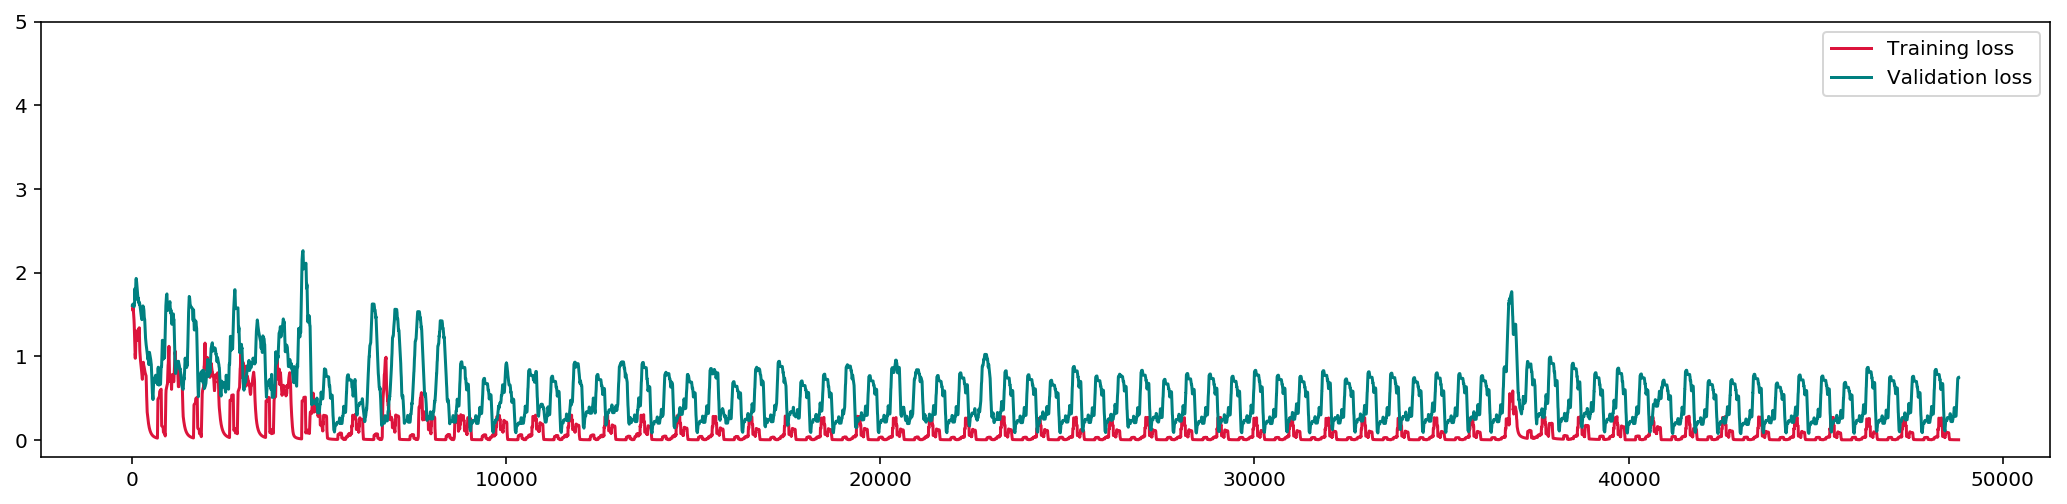

In [50]:

smoothed_loss = hm.running_mean(losses['train'], 100)
smoothed_loss_train = hm.running_mean(losses['validation'], 250)

fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
plt.ylim([-0.2,5])
plt.show()

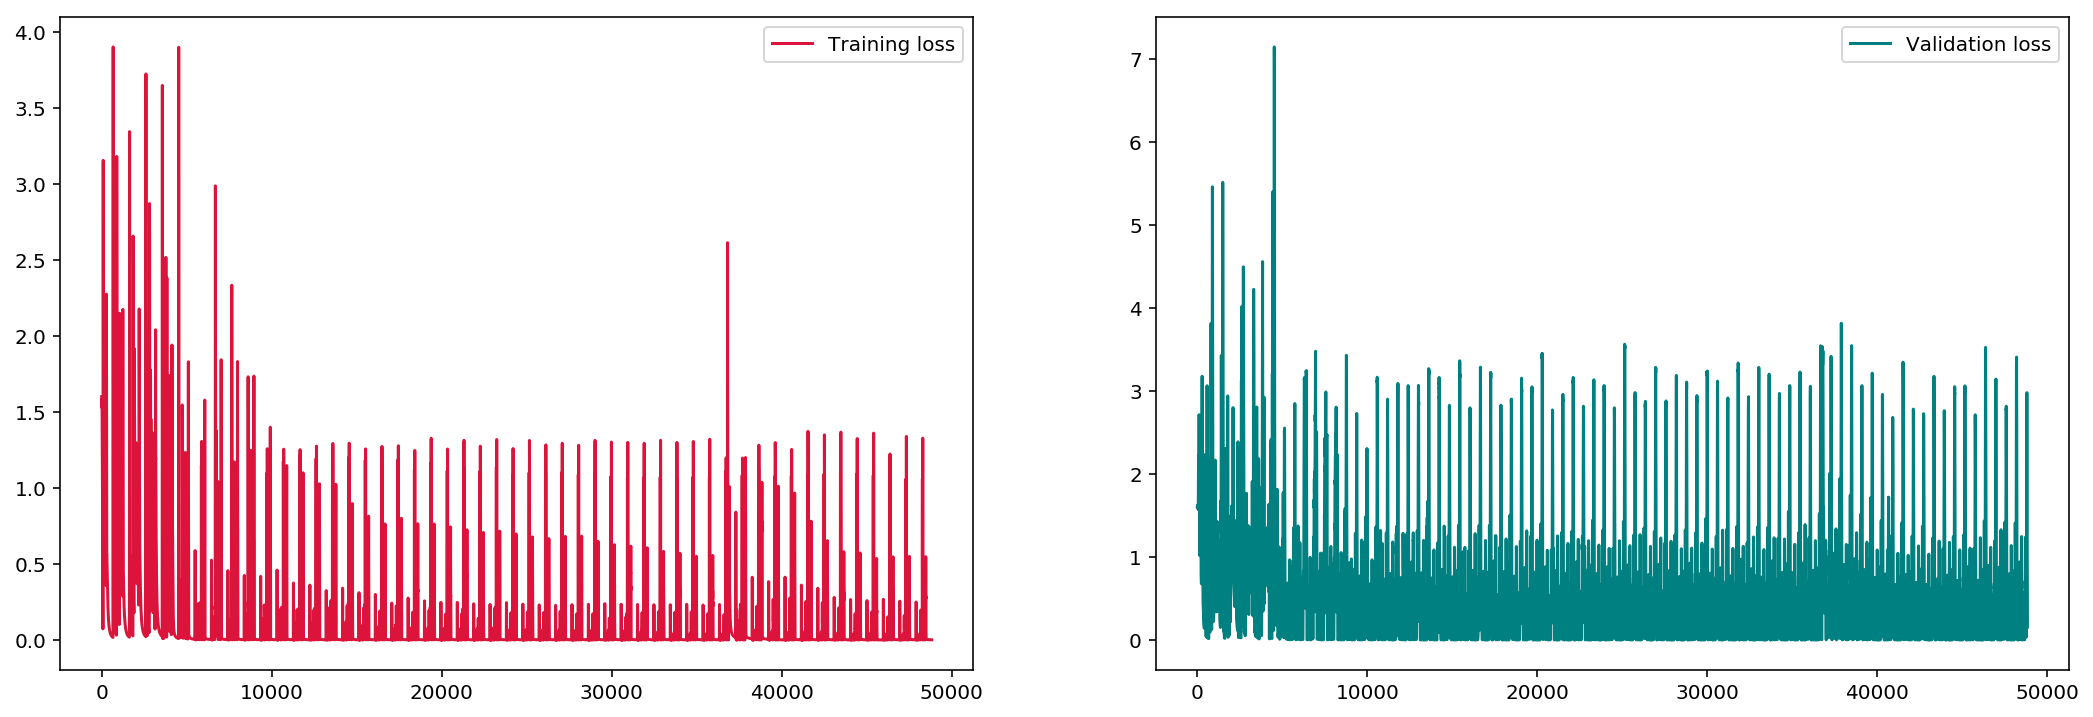

In [51]:
smoothed_loss = hm.running_mean(losses['train'], 10)
smoothed_loss_train = hm.running_mean(losses['validation'], 25)

fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax2.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()

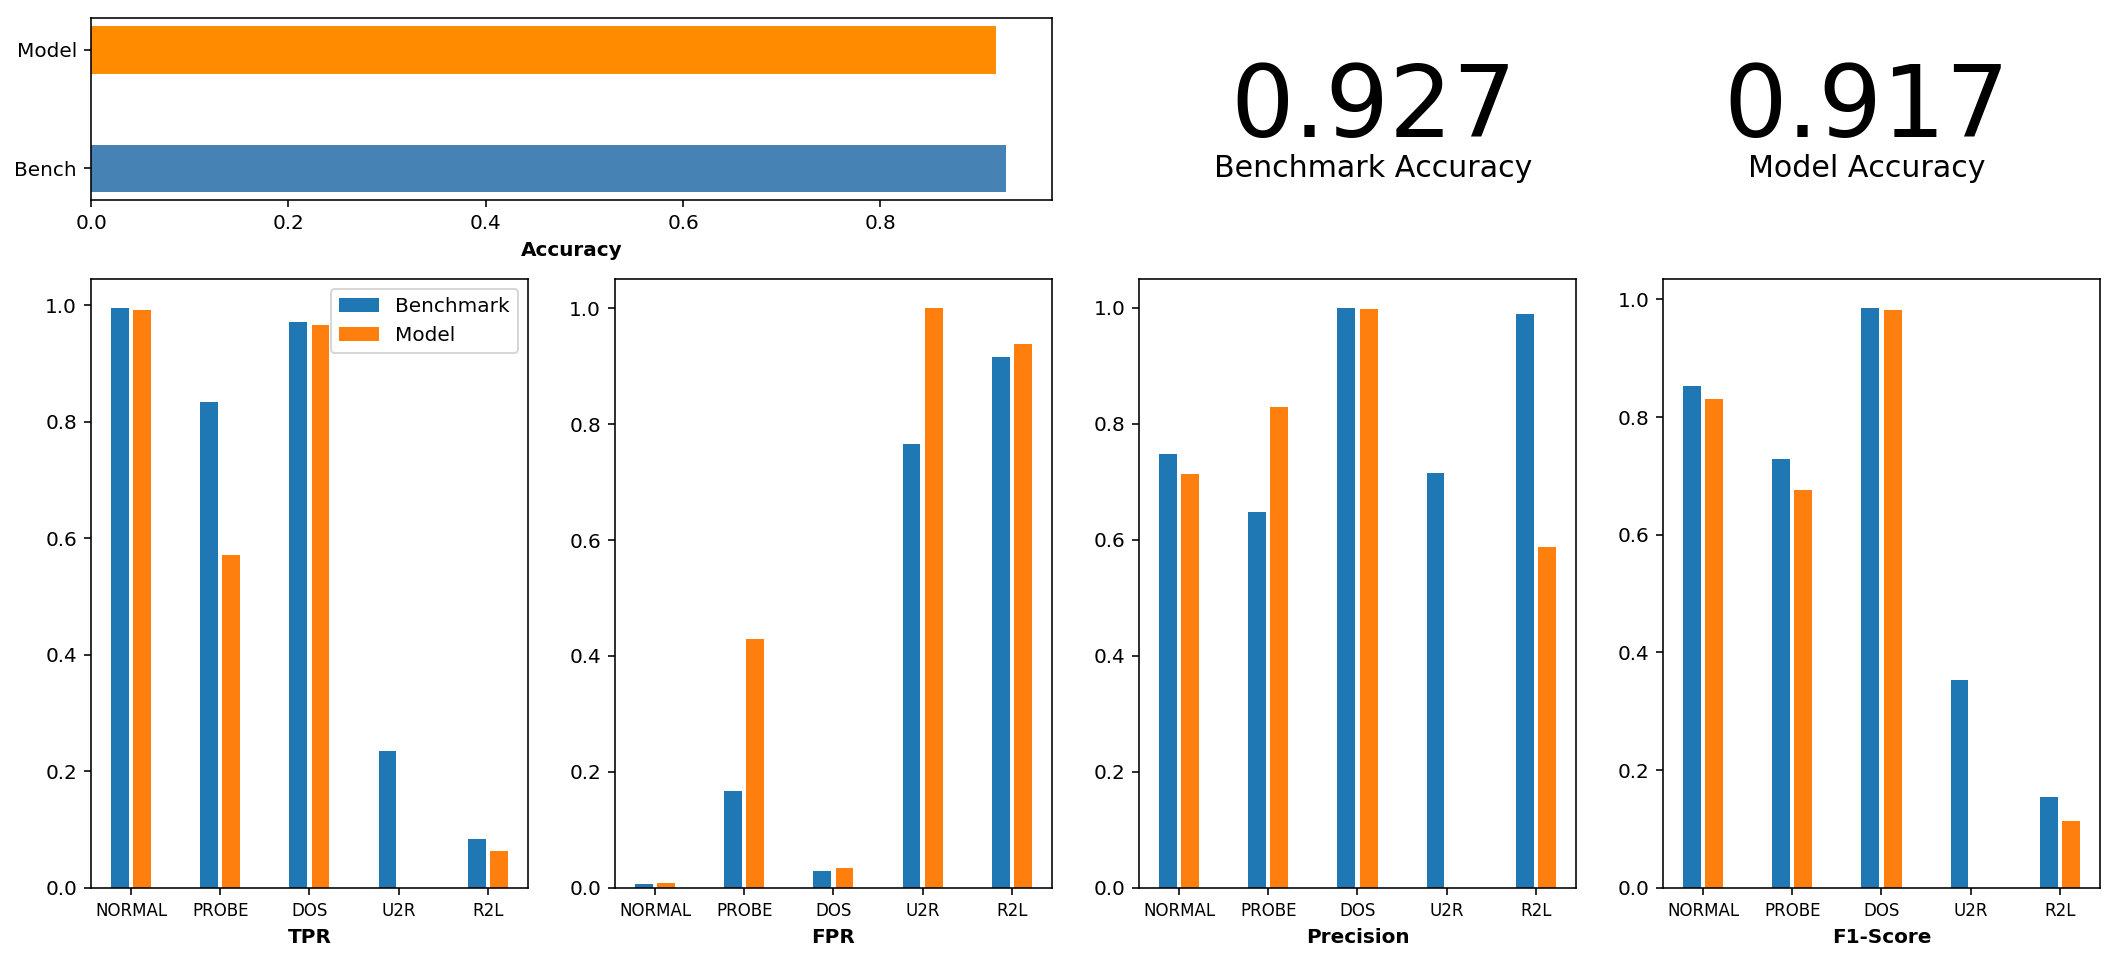

In [52]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
hm.plotMetrics(metrics)

